# Случайный лес

В этом практическом задании вы решите задачу регрессии на реальных данных при помощи линейной модели и случайного леса. 

## Цели практической работы

* Научиться применять случайный лес в задаче регрессии.
* Научиться сравнивать качество случайного леса с качеством линейной модели.
* Научиться настраивать гиперпараметры леса.

## Что входит в работу

* Выполнить предобработку данных.
* Обучить линейную регрессию на данных задачи.
* Обучить случайный лес на данных задачи.
* Подобрать гиперпараметры для леса.
* Визуализировать важность признаков у леса.

## Что оценивается

*  Все ячейки заполнены; при запуске ячеек  Python не выдаёт информацию об ошибках.
*  Качество итоговой модели $R^2$ превышает 0,95.


## Что нужно сделать

Постройте модели, предсказывающие стоимость автомобилей по характеристикам.

Признаков у машин много, но в этой работе обойдёмся только числовыми признаками:
*  year — год производства автомобиля;
*  km_driven — пробег;
*  seats — количество посадочных мест;
*  mileage — другая характеристика пробега;
*  engine — мощность двигателя;
*  max_power — мощность автомобиля.

Целевая переменная — selling_price.

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

train = pd.read_csv("cars_train.csv")
test = pd.read_csv("cars_test.csv")

In [2]:
# посмотрим на датафрейм
train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,"Maruti Swift VXI BSIII,2007,130000,120000,Petr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hyundai Xcent 1.2 VTVT E Plus,2017.0,440000.0,45000.0,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,Hyundai i20 Magna,2013.0,320000.0,110000.0,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
6994,"Hyundai Verna CRDi SX,2007,135000,119000,Diese...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6995,Maruti Swift Dzire ZDi,2009.0,382000.0,120000.0,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
6996,Tata Indigo CR4,2013.0,290000.0,25000.0,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [3]:
#Создадим датафрейм только из числовых колонок для тренеровочного датафрейма
df_train = train[['year', 'km_driven', 'seats', 'mileage', 'engine', 'max_power', 'selling_price']]

df_train

,year,km_driven,seats,mileage,engine,max_power,selling_price
0,2014.0,145500.0,5.0,23.4 kmpl,1248 CC,74 bhp,450000.0
1,2014.0,120000.0,5.0,21.14 kmpl,1498 CC,103.52 bhp,370000.0
2,2010.0,127000.0,5.0,23.0 kmpl,1396 CC,90 bhp,225000.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017.0,45000.0,5.0,20.14 kmpl,1197 CC,81.86 bhp,440000.0
...,...,...,...,...,...,...,...
6993,2013.0,110000.0,5.0,18.5 kmpl,1197 CC,82.85 bhp,320000.0
6994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6995,2009.0,120000.0,5.0,19.3 kmpl,1248 CC,73.9 bhp,382000.0
6996,2013.0,25000.0,5.0,23.57 kmpl,1396 CC,70 bhp,290000.0


In [4]:
# Убираем буквы из столбцов и преобразуем в числа

import re

# Функция для извлечения числовых значений из строки, игнорируя NaN
def extract_numeric(value):
    if pd.notna(value):
        matches = re.findall(r'\d+\.\d+|\d+', str(value))
        if matches:
            return float(matches[0])
    return value

# Применяем функцию к каждой колонке
df_train['mileage'] = df_train['mileage'].apply(extract_numeric)
df_train['engine'] = df_train['engine'].apply(extract_numeric)
df_train['max_power'] = df_train['max_power'].apply(extract_numeric)

df_train

,year,km_driven,seats,mileage,engine,max_power,selling_price
0,2014.0,145500.0,5.0,23.40,1248.0,74.00,450000.0
1,2014.0,120000.0,5.0,21.14,1498.0,103.52,370000.0
2,2010.0,127000.0,5.0,23.00,1396.0,90.00,225000.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017.0,45000.0,5.0,20.14,1197.0,81.86,440000.0
...,...,...,...,...,...,...,...
6993,2013.0,110000.0,5.0,18.50,1197.0,82.85,320000.0
6994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6995,2009.0,120000.0,5.0,19.30,1248.0,73.90,382000.0
6996,2013.0,25000.0,5.0,23.57,1396.0,70.00,290000.0


In [5]:
#Проверим датафрейм на пропуски

df_train.isna().sum()

year             299
km_driven        299
seats            501
mileage          501
engine           501
max_power        495
selling_price    299
dtype: int64

In [6]:
#Выведим строки со значениями NaN

df_train[pd.isna(df_train).any(axis=1)]

,year,km_driven,seats,mileage,engine,max_power,selling_price
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2007.0,80000.0,NaN,NaN,NaN,NaN,200000.0
28,2003.0,50000.0,NaN,NaN,NaN,NaN,70000.0
69,2003.0,70000.0,NaN,NaN,NaN,NaN,50000.0
...,...,...,...,...,...,...,...
6957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6975,2006.0,100000.0,NaN,NaN,NaN,NaN,130000.0
6976,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Удалим строки с NaN значениями

df_train = df_train.fillna(df_train.mean())

# df_train.dropna(how='any', inplace=True)

In [8]:
df_train.isna().sum()

year             0
km_driven        0
seats            0
mileage          0
engine           0
max_power        0
selling_price    0
dtype: int64

In [9]:
df_train.info()

#Видим что остались только числовые значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           6998 non-null   float64
 1   km_driven      6998 non-null   float64
 2   seats          6998 non-null   float64
 3   mileage        6998 non-null   float64
 4   engine         6998 non-null   float64
 5   max_power      6998 non-null   float64
 6   selling_price  6998 non-null   float64
dtypes: float64(7)
memory usage: 382.8 KB


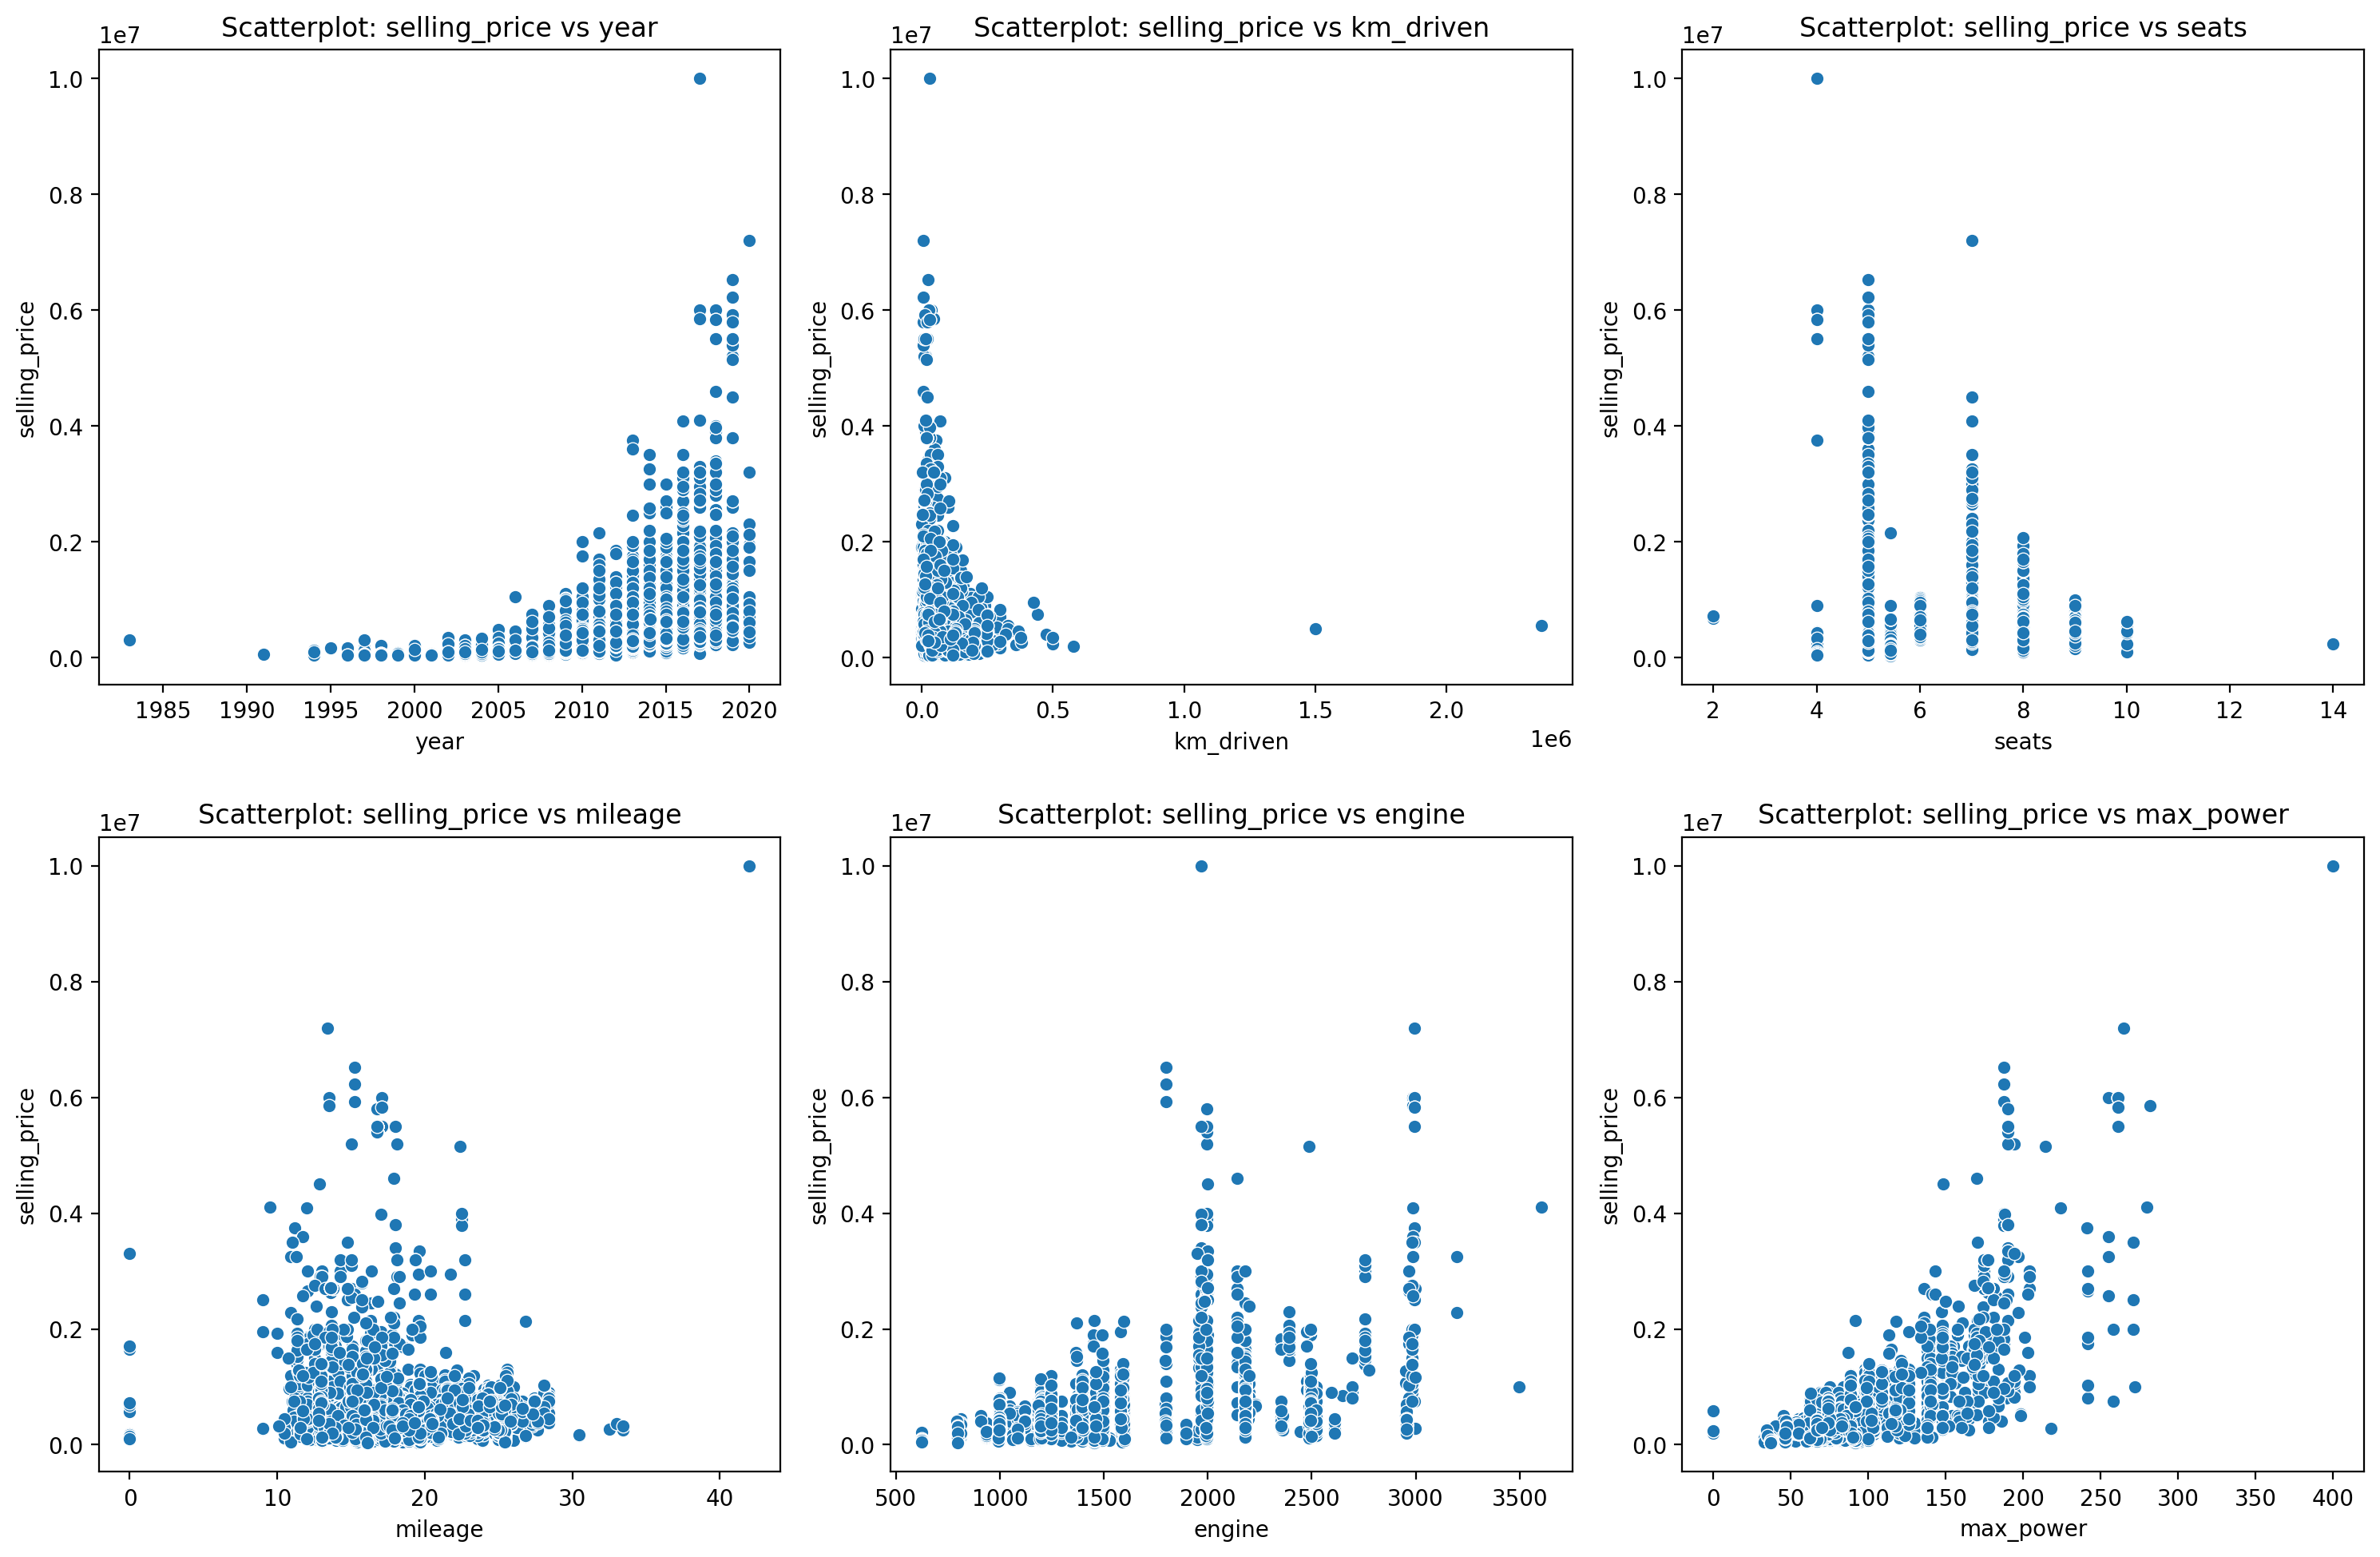

In [10]:
# Посмотрим на распределение значении по целевой переменно. Создадим скаттерплоты

import matplotlib.pyplot as plt
import seaborn as sns

# Удаляем столбец с целевой переменной "selling_price" для получения списка переменных
variables = df_train.drop('selling_price', axis=1).columns

# Определяем количества строк и столбцов в сетке графиков
num_rows = len(variables) // 3 + (len(variables) % 3 > 0)
num_cols = min(3, len(variables))

# Создаем сетку графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=200)

# Проходим по переменным и строим скаттерплоты
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.scatterplot(x=variable, y='selling_price', data=df_train, ax=axes[row, col])
    axes[row, col].set_title(f'Scatterplot: selling_price vs {variable}')

# Размещаем графики
plt.tight_layout()
plt.show()

По графикам видим что есть линейные зависимости, но видим еще и выбросы. Поработаем над ними

In [11]:
df_train.sort_values(by='selling_price', ascending=False).head(30)

,year,km_driven,seats,mileage,engine,max_power,selling_price
151,2017.0,30000.0,4.0,42.00,1969.0,400.00,10000000.0
2532,2020.0,5000.0,7.0,13.38,2993.0,265.00,7200000.0
4231,2019.0,23600.0,5.0,15.26,1798.0,187.74,6523000.0
4229,2019.0,7800.0,5.0,15.26,1798.0,187.74,6223000.0
921,2018.0,28156.0,4.0,17.09,2993.0,261.40,6000000.0
3505,2018.0,28156.0,4.0,17.09,2993.0,261.40,6000000.0
4075,2018.0,27000.0,4.0,17.09,2993.0,261.40,6000000.0
121,2017.0,37000.0,5.0,13.50,2987.0,254.79,6000000.0
4230,2019.0,11500.0,5.0,15.26,1798.0,187.74,5923000.0
132,2017.0,47000.0,5.0,13.50,2987.0,282.00,5850000.0


Цена в 10миллионов будет восприниматься как выброс. Даже если это какой нибудь реаритетный авто, модель будет плохо справляться изза единственного экземпляра

In [12]:
# Удаляем строку по индексу

index_to_drop = 151
df_train = df_train.drop(index_to_drop, errors='ignore')

In [13]:
# Проверим так же колонку 

df_train.sort_values(by='km_driven', ascending=False).head(10)

,year,km_driven,seats,mileage,engine,max_power,selling_price
3003,2007.0,2360457.0,5.0,18.60,1197.0,81.83,550000.0
1551,2012.0,1500000.0,7.0,15.10,2179.0,140.00,500000.0
3023,2010.0,577414.0,5.0,18.90,1061.0,67.00,194000.0
5734,2011.0,500000.0,7.0,12.99,2494.0,100.57,350000.0
3137,2011.0,500000.0,5.0,18.90,998.0,67.10,229999.0
4365,2011.0,475000.0,5.0,13.50,2179.0,115.00,400000.0
4433,2013.0,440000.0,7.0,12.99,2494.0,100.60,750000.0
4680,2010.0,426000.0,7.0,12.80,2494.0,102.00,950000.0
1961,2010.0,380000.0,7.0,13.60,2523.0,63.00,260000.0
6106,2007.0,376412.0,8.0,12.80,2494.0,102.00,350000.0


In [14]:
# Слишком большие значения пробега(дайте покататься на таком бессмертном). Удалим колонки по индексу

index_to_drop = [3003, 1551]
df_train = df_train.drop(index_to_drop, errors='ignore')

In [15]:
# Еще мне на глаза попался точка в посадочных местах

df_train.sort_values(by='seats', ascending=False).head(10)

,year,km_driven,seats,mileage,engine,max_power,selling_price
3906,2010.0,50000.0,14.0,10.71,1948.0,90.0,235000.0
6398,2016.0,120000.0,10.0,13.58,2499.0,72.4,620000.0
2831,2015.0,110000.0,10.0,13.58,2499.0,72.4,580000.0
5895,2015.0,120000.0,10.0,13.58,2499.0,72.4,434000.0
690,2016.0,60000.0,10.0,12.20,1994.0,105.3,409999.0
3515,2000.0,120000.0,10.0,12.20,1948.0,68.0,95000.0
4268,2002.0,290000.0,10.0,13.10,2446.0,75.0,229999.0
2011,2014.0,110000.0,10.0,13.58,2499.0,72.4,600000.0
6300,2013.0,120000.0,10.0,13.58,2499.0,72.4,454000.0
6534,2016.0,120000.0,10.0,13.58,2499.0,72.4,620000.0


In [16]:
# Удалим газель

index_to_drop = 3906
df_train = df_train.drop(index_to_drop, errors='ignore')

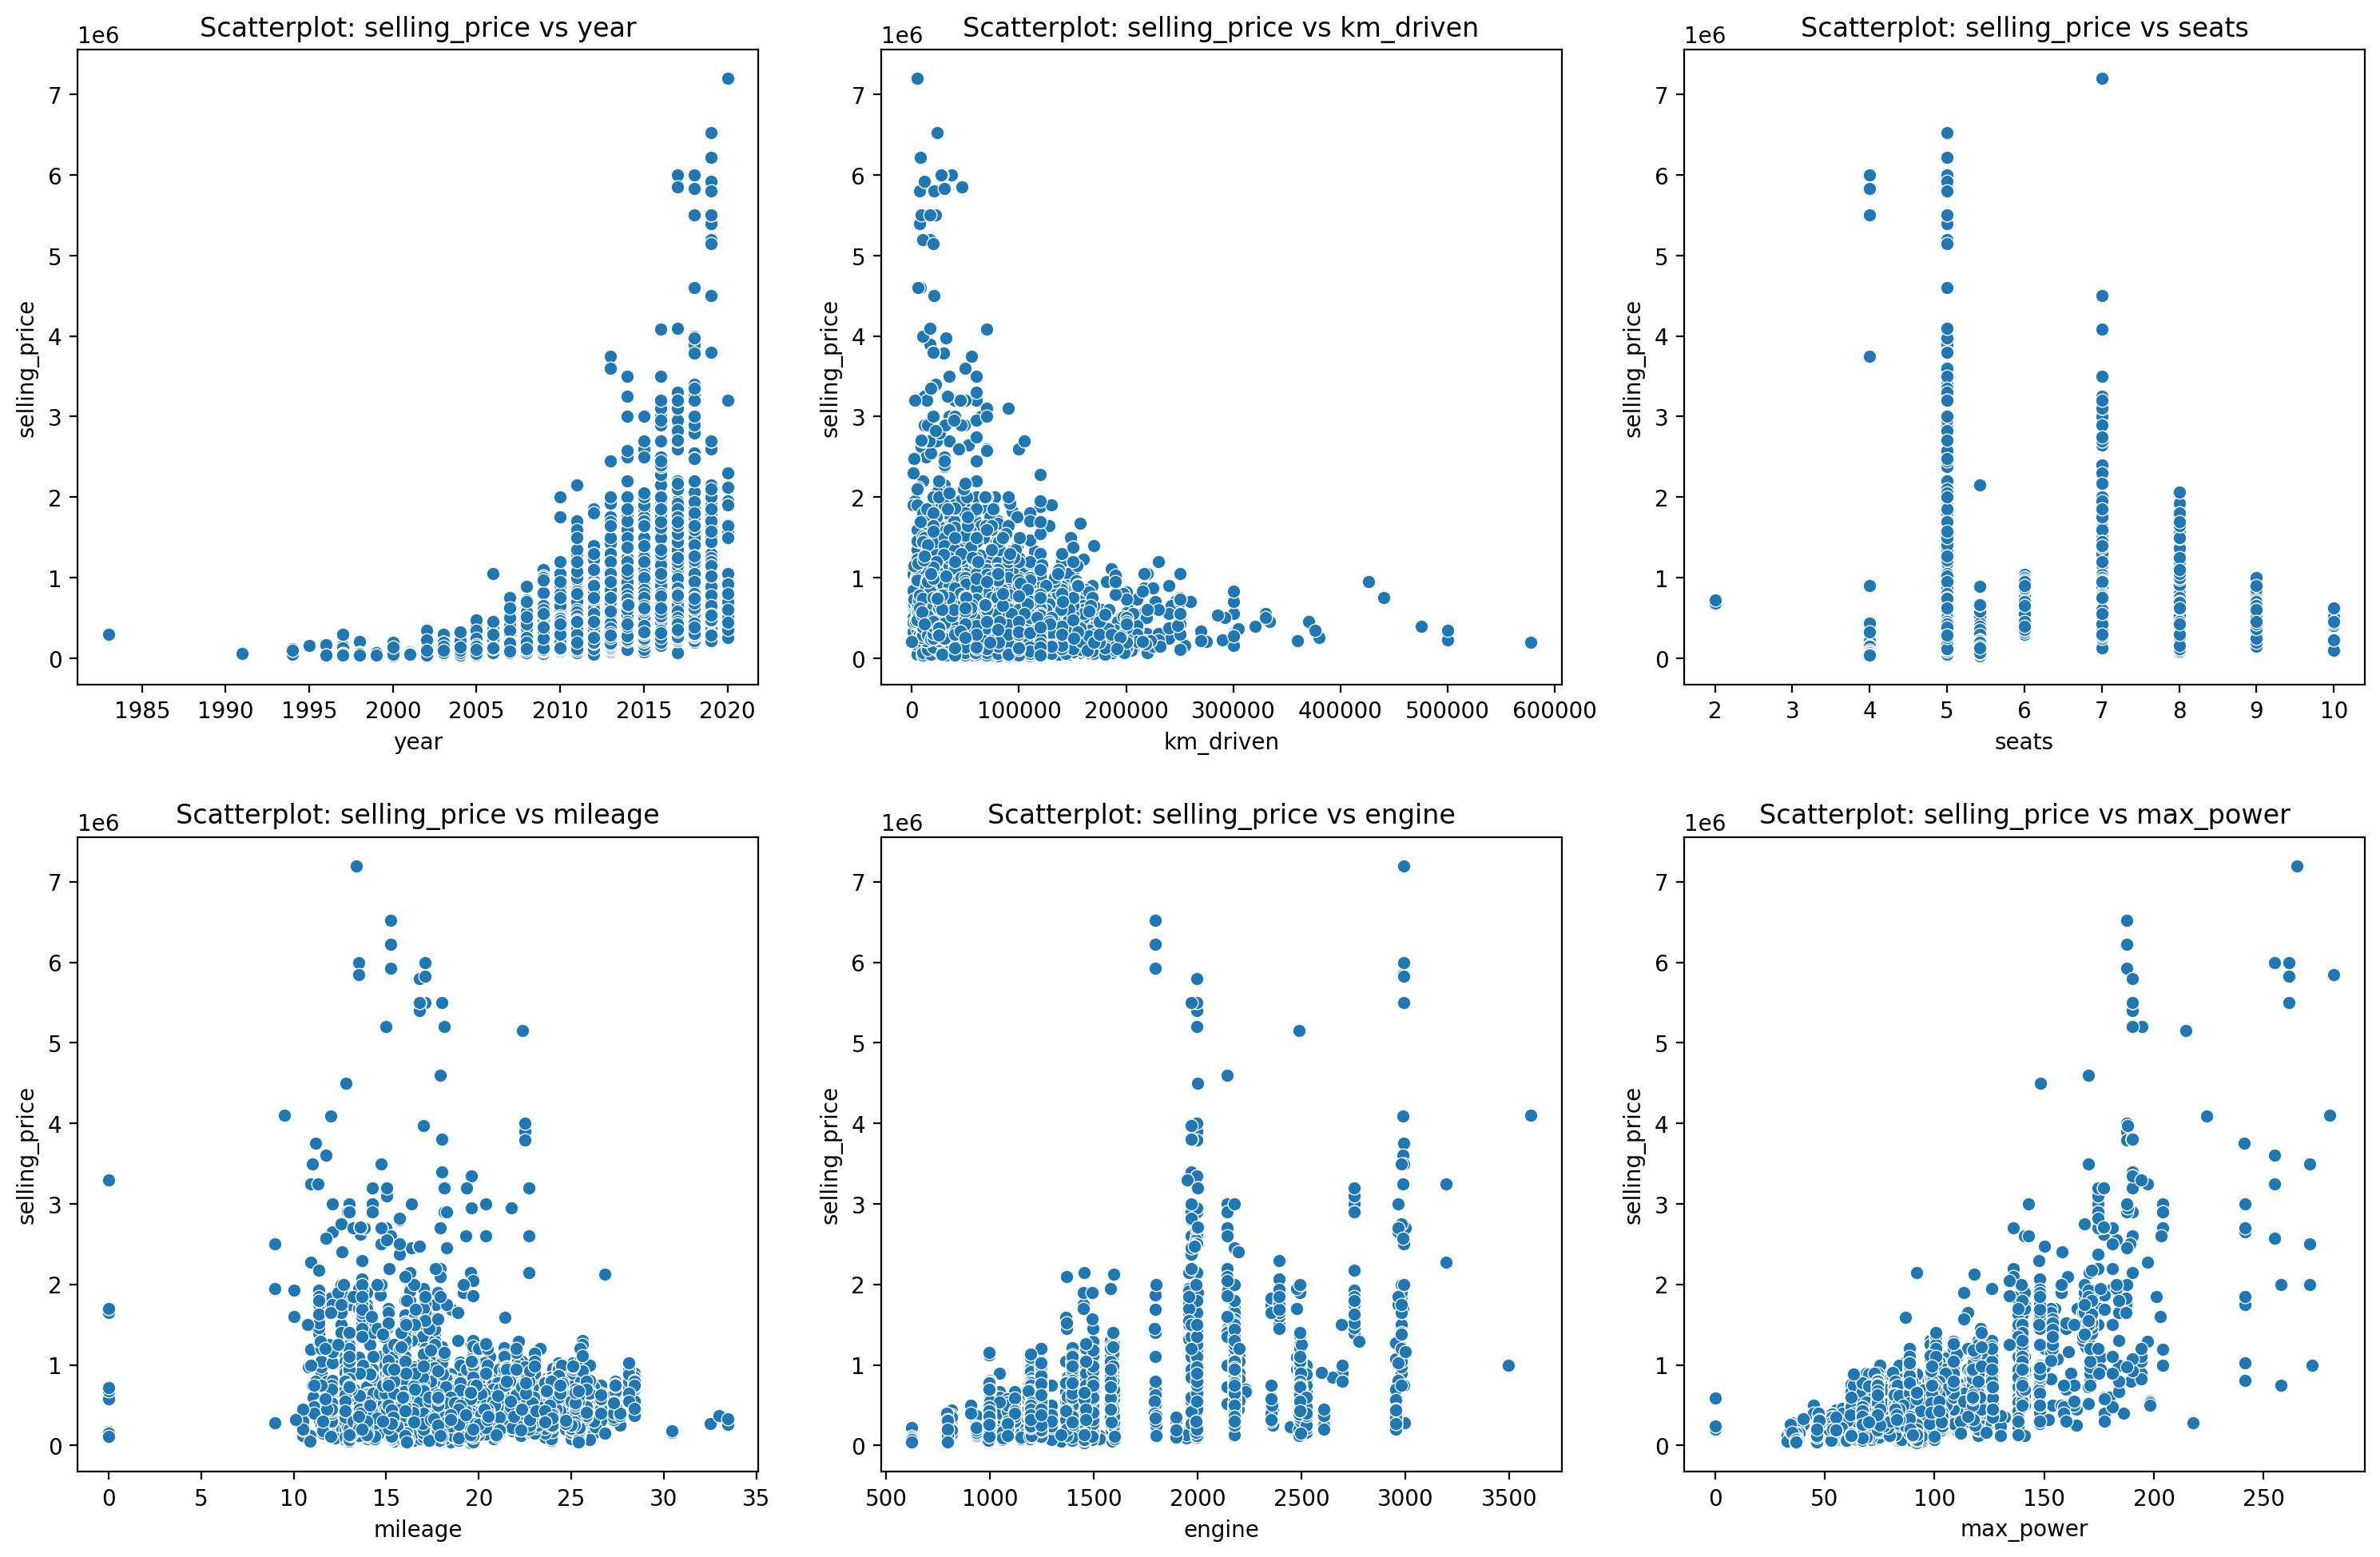

In [20]:
# Посмотрим на распределение значении по целевой переменной еще раз

# Удаляем столбец с целевой переменной "selling_price" для получения списка переменных
variables = df_train.drop('selling_price', axis=1).columns

# Определяем количества строк и столбцов в сетке графиков
num_rows = len(variables) // 3 + (len(variables) % 3 > 0)
num_cols = min(3, len(variables))

# Создаем сетку графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=200)

# Проходим по переменным и строим скаттерплоты
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.scatterplot(x=variable, y='selling_price', data=df_train, ax=axes[row, col])
    axes[row, col].set_title(f'Scatterplot: selling_price vs {variable}')

# Размещаем графики
plt.tight_layout()
plt.show()

Теперь мы точно можем сказать как фичи коррелируют с целевым признаком. Например чем новее год производства тем выше цена(экспоненциальный рост), или что чем меньше пробег тем дороже автомобиль. Количество мест не дает явных ответов, но можно сказать что 5 мест это самый популярный из выборки, оно присудствуюет во всех(почти) ценавых сегментах. Так же можно сказать и про мощность двигателя. Не смотря на то что оно тоже показывает линейный рост, мы можем увидеть что в районе 2000 и 3000 большое скопление. Возможно это потому что именно таких автомобилей(с 5 посадочными местами и 2000/3000 мощьностью двигателя) больше всего на рынке. Что нельзя сказать про колонку mileage. На сколько я понял это расход топлива на километр. Икак мы видим значения этой колонки почти что не влияют на цену. Если это не так можно удалить колонку при условии что модель не сможет хорошо обучиться


Сделаем все шаги и для тестового датафрейма

In [21]:
# Посмотрим на тестовый датафрейм
test

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0


In [22]:
df_test = test[['year', 'km_driven', 'seats', 'mileage', 'engine', 'max_power', 'selling_price']]

df_test

,year,km_driven,seats,mileage,engine,max_power,selling_price
0,2010,168000,7.0,14.0 kmpl,2498 CC,112 bhp,229999
1,2017,25000,5.0,21.5 kmpl,1497 CC,108.5 bhp,665000
2,2007,218463,5.0,12.9 kmpl,1799 CC,130 bhp,175000
3,2015,173000,5.0,25.1 kmpl,1498 CC,98.6 bhp,635000
4,2011,70000,5.0,16.5 kmpl,1172 CC,65 bhp,130000
...,...,...,...,...,...,...,...
995,2008,100000,5.0,19.81 kmpl,1086 CC,68.05 bhp,250000
996,2017,50000,5.0,18.6 kmpl,1197 CC,81.83 bhp,440000
997,2009,40000,5.0,23.0 kmpl,1396 CC,90 bhp,340000
998,2012,25000,5.0,20.36 kmpl,1197 CC,78.9 bhp,350000


In [23]:
df_test.isna().sum()

year              0
km_driven         0
seats            19
mileage          19
engine           19
max_power        19
selling_price     0
dtype: int64

In [24]:
# Удаляем пропуски

df_test.dropna(how='any', inplace=True)

In [25]:
df_test.isna().sum()

year             0
km_driven        0
seats            0
mileage          0
engine           0
max_power        0
selling_price    0
dtype: int64

In [26]:
# Убираем буквы из столбцов и преобразуем в числа

df_test['mileage'] = df_test['mileage'].str.extract('(\d+\.\d+)').astype(float)

df_test['engine'] = df_test['engine'].str.extract('(\d+)').astype(int)

df_test['max_power'] = df_test['max_power'].str.extract('(\d+)').astype(int)

df_test

,year,km_driven,seats,mileage,engine,max_power,selling_price
0,2010,168000,7.0,14.00,2498,112,229999
1,2017,25000,5.0,21.50,1497,108,665000
2,2007,218463,5.0,12.90,1799,130,175000
3,2015,173000,5.0,25.10,1498,98,635000
4,2011,70000,5.0,16.50,1172,65,130000
...,...,...,...,...,...,...,...
995,2008,100000,5.0,19.81,1086,68,250000
996,2017,50000,5.0,18.60,1197,81,440000
997,2009,40000,5.0,23.00,1396,90,340000
998,2012,25000,5.0,20.36,1197,78,350000


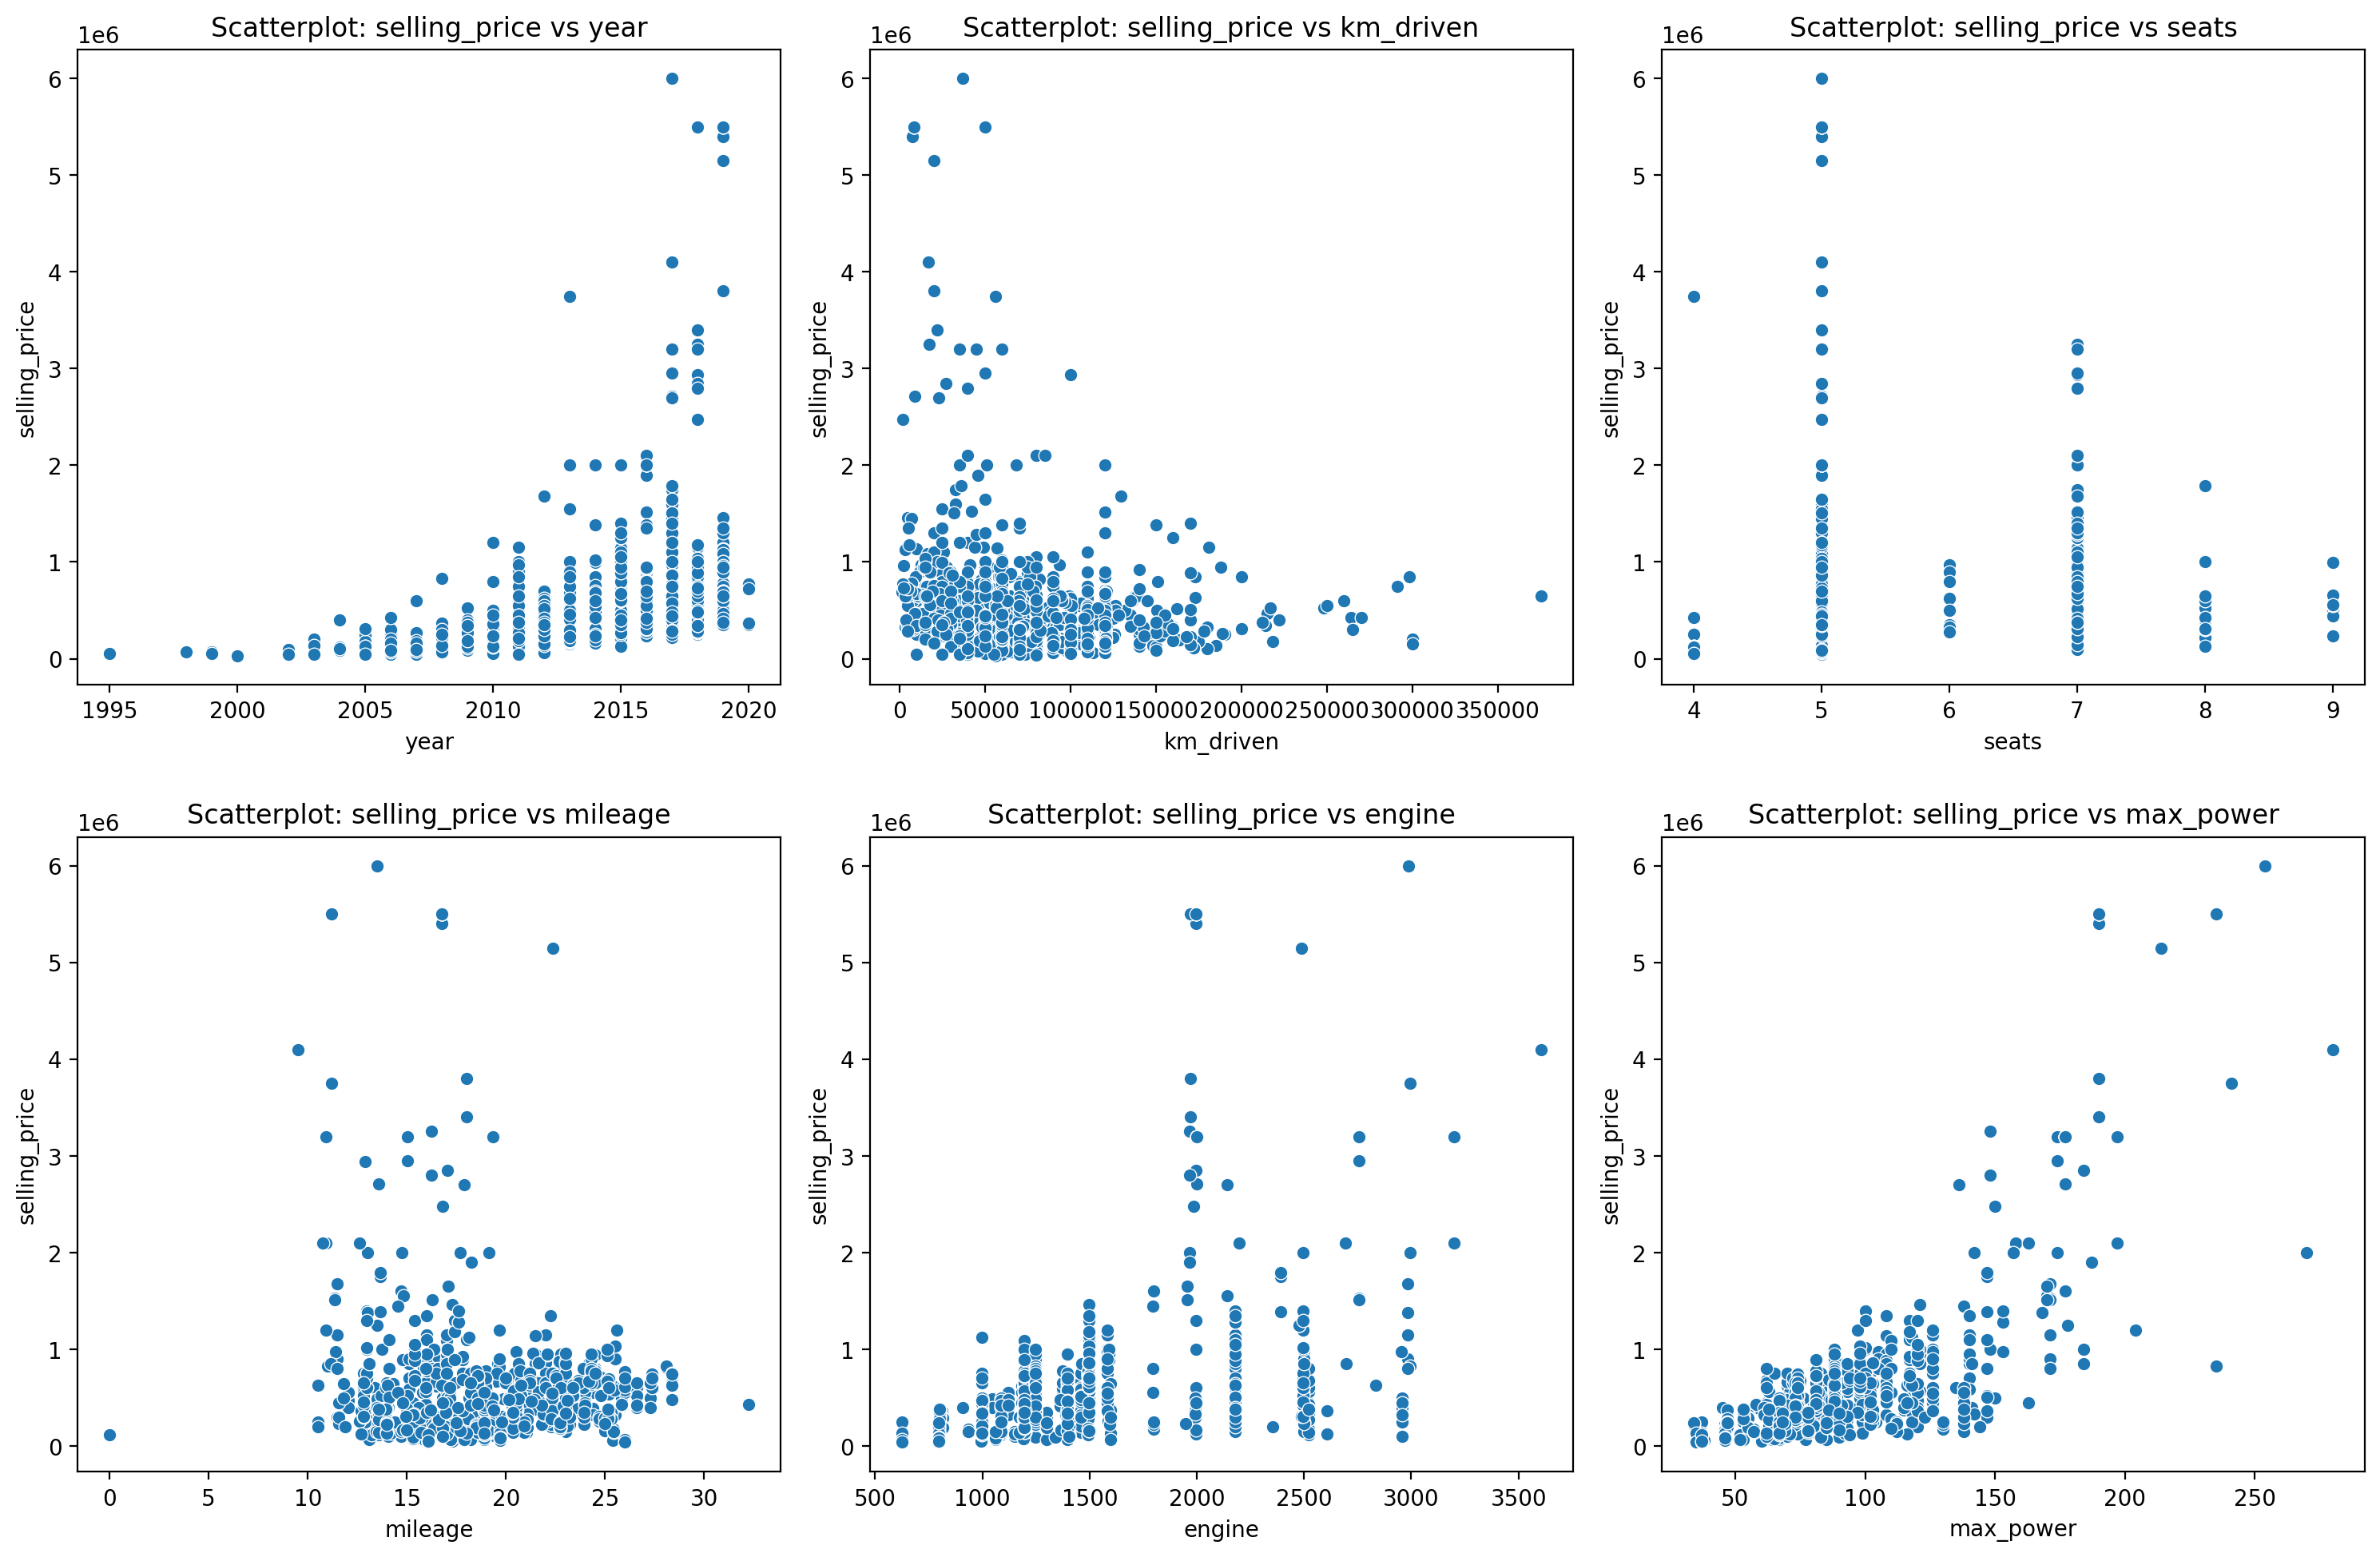

In [27]:
# Посмотрим на распределение значении по целевой переменной в тестовых данных

# Удаляем столбец с целевой переменной "selling_price" для получения списка переменных
variables = df_test.drop('selling_price', axis=1).columns

# Определяем количества строк и столбцов в сетке графиков
num_rows = len(variables) // 3 + (len(variables) % 3 > 0)
num_cols = min(3, len(variables))

# Создаем сетку графиков
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), dpi=200)

# Проходим по переменным и строим скаттерплоты
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.scatterplot(x=variable, y='selling_price', data=df_test, ax=axes[row, col])
    axes[row, col].set_title(f'Scatterplot: selling_price vs {variable}')

# Размещаем графики
plt.tight_layout()
plt.show()

Графики схожие. Можно продолжать работу

Создайте объекты Xtrain, ytrain, Xtest, ytest. Запишите в них матрицы «объект — признак» и векторы целевой переменной для тренировочного и тестового датасетов.

In [28]:
# Ваш код здесь

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X = df_train.drop(['selling_price'], axis=1)
y = df_train['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Xtest = df_test.drop(['selling_price'], axis=1)
ytest = df_test['selling_price']

В тренировочных данных есть автомобили, для которых неизвестна стоимость. Удалите эти автомобили из трейна.

In [29]:
# Ваш код здесь

Перед обучением моделей обработайте данные.

Обратите внимание, что столбцы mileage, engine и max_power по смыслу числовые. Чтобы превратить их в числовые столбцы, отбросьте единицы измерения и оставьте только числа. В столбцах есть пропущенные значения, их при обработке трогать не нужно.

In [30]:
# Ваш код здесь

Оставьте в данных только шесть числовых столбцов:

year, km_driven, seats, engine, mileage, max_power

In [31]:
# Ваш код здесь

Теперь заполните пропуски следующим образом:

*    вычислите средние значения по столбцам тренировочной выборки;

*    добавьте в пропуски в тренировочных и тестовых данных вычисленные средние.

In [32]:
# Ваш код здесь

Теперь на обработанных тренировочных данных обучите:

*  линейную регрессию,
*  случайный лес с параметрами по умолчанию.

На обработанных тестовых данных сделайте предсказание и вычислите метрику $R^2$. 

In [38]:
# Ваш код здесь

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Обучение линейной регрессии
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Обучение случайного леса
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Предсказание на тестовых данных
linreg_predictions = linreg.predict(X_test)
rfr_predictions = rfr.predict(X_test)

# Вычисление метрики R2
r2_linreg = r2_score(y_test, linreg_predictions)
r2_rfr = r2_score(y_test, rfr_predictions)

# Вывод результатов
print(f'R2 для линейной регрессии: {r2_linreg}')
print(f'R2 для случайного леса: {r2_rfr}')

R2 для линейной регрессии: 0.6164191305387168
R2 для случайного леса: 0.9618598552402393


Какая модель получилась лучше?

In [34]:
# Ваш ответ здесь

# Лучше получилась модель Случайных лесов со значением R2 - 0.96

Улучшите качество предсказания случайного леса путём подбора гиперпараметров:

*   n_estimators,
*   max_depth,
*   max_features,
*   min_samples_leaf,
*   min_samples_split.

Для подбора гиперпараметров используйте GridSearchCV. Обучайте GridSearchCV по тренировочным данным с разбивкой на три фолда и метрикой $R^2$.

In [39]:
# Ваш код здесь

from sklearn.model_selection import GridSearchCV

# Определение параметров для GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Создание модели случайного леса
random_forest = RandomForestRegressor(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='r2', verbose=2)

# Обучение GridSearchCV
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
print(f"Наилучшие параметры: {grid_search.best_params_}")

# Получение наилучшей модели
best_rf_model = grid_search.best_estimator_

# Предсказание на тестовых данных
best_rf_predictions = best_rf_model.predict(X_test)

# Вычисление метрики R2
r2_best_rf = r2_score(y_test, best_rf_predictions)

# Вывод результата
print(f'R2 для наилучшей модели случайного леса: {r2_best_rf}')

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, ma

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None

[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, m

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, 

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=s

[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=log2, m

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, m

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=sq

[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, max_features=log2, 

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, m

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sq

[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, 

Теперь обучите на тренировочных данных случайный лес с найденными гиперпараметрами. Сделайте предсказание на тестовых данных и оцените его качество ($R^2$).

In [40]:
# Ваш код здесь

model = RandomForestRegressor(max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)
model.fit(X, y)

y_pred = model.predict(Xtest)

r2_model = r2_score(ytest, y_pred)

print(f'R2 для случайного леса с найденными гиперпараметрами: {r2_model}')

R2 для случайного леса с найденными гиперпараметрами: 0.958856399713756


Модель готова. Осталось её проинтерпретировать.

При помощи метода model.feature_importances_ визуализируйте гистограмму важности признаков у случайного леса с настроенными гиперпараметрами.

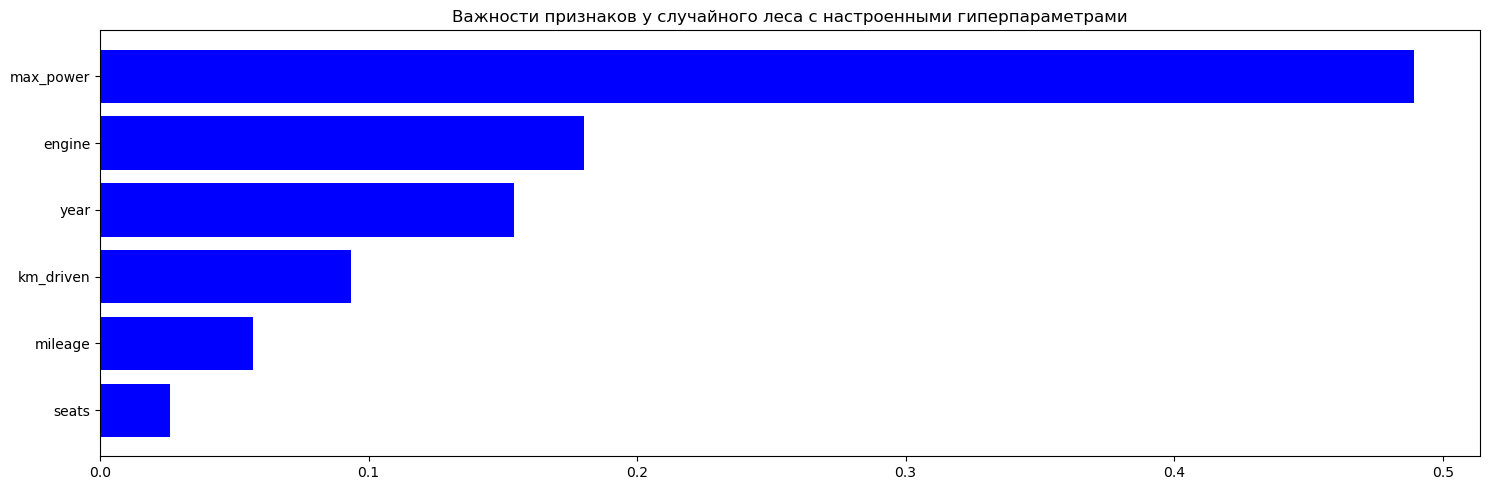

In [41]:
# Ваш код здесь

feature_importances = model.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importances)

plt.figure(figsize=(15, 5))

plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Важности признаков у случайного леса с настроенными гиперпараметрами')

plt.tight_layout()
plt.show()

Больше всего ценности для модели несет признак max_power(мощьность автомобиля), после него мощьность двигателя и год производства